<a href="https://colab.research.google.com/github/felipemonsalvez/esp-idf/blob/master/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lectura de dataset**
----

(0.0, 1.0)

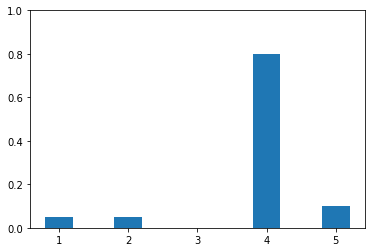

In [1]:
import matplotlib.pyplot as plt

plt.bar([1,2,3,4,5],[0.05,0.05,0,0.8,0.1],width=0.4)
plt.ylim([0,1])

In [2]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def not_in_sequence(i,j,SIS):
    for index in range(len(SIS)-1):
        if((SIS[index] == i and SIS[index+1] == j) or (SIS[index] == j and SIS[index+1] == i)):
            return False
    return True

def signal_image(signals):
    SI = [signals[:,0]] #Signal Image, collection of sequences
    SIS = [0] #Signal index string, keeps record of the order of added sequences to SI
    Ns = signals.shape[1] #Total number of different sequences
    Nsis = 1 #Number of added sequences
    i = 0
    j = 1
    while(i != j):
        if(j > Ns-1):
            j = 0
        elif(not_in_sequence(i,j,SIS)):
            SI.append(signals[:,j])
            SIS.append(j)
            Nsis = Nsis + 1
            i = j
            j = i + 1
        else:
            j = j + 1
    return SI[0:len(SI)-1], SIS, Nsis, Ns

def signal_images(input):
    Signal_images = []
    for i in range(input.shape[0]):
        Signal_images.append(signal_image(input[i,:,:])[0])
    return np.array(Signal_images, dtype = np.float32)

def one_hot_encode(y, nclasses):
  y_one_hot = []
  for j in range(len(y)):
    a = np.zeros(nclasses)
    a[y[j]] = 1.
    y_one_hot.append(a)
  return np.array(y_one_hot)

def transform_scale(x):
  x = tf.signal.rfft2d(x)
  x = tf.abs(x)
  x = tf.math.divide(tf.subtract(x, tf.reduce_min(x)), tf.subtract(tf.reduce_max(x), tf.reduce_min(x)))
  #x = tf.reshape(x, shape = [-1, x.shape[1], x.shape[2], 1])
  return x

In [3]:
path = '/content/drive/MyDrive/data_gateway/'
files = listdir(path)

X = []
Y = []
for f in files:
  data = pd.read_csv(path+f)
  for i in range(len(data)):
    #rms1 = np.sqrt(data.iloc[i].values[1]**2+data.iloc[i].values[3]**2+data.iloc[i].values[5]**2)
    #rms2 = np.sqrt(data.iloc[i].values[2]**2+data.iloc[i].values[4]**2+data.iloc[i].values[6]**2)
    #x_i = [rms1,rms2]
    #for dato in data.iloc[i].values[1:12]:
    #  x_i.append(dato)
    #X.append(x_i)
    X.append(data.iloc[i].values[1:7])
    if len(f) < 8:
      Y.append(f[:-4])
    else:
      Y.append(f[:-7])


In [4]:
df = pd.DataFrame(X)    # Dataset completo incluyendo las clases
df['Label'] = Y

timesteps = 105                          # timesteps
nchannels = len(df.columns)-1            # num canales (accx, accy, accz, etc)
nclasses = len(df['Label'].unique())     # num clases

X0 = []
Y0 = []

for label in df['Label'].unique():
  aux = df.loc[df['Label']==label]
  X0.append(aux.loc[:, aux.columns!='Label'].values)      # X0 contiene nclasses elementos con las series de cada clase
  Y0.append(aux['Label'].values[0])                       # Y0 contiene las clases en orden de aparición      

X1 = []
for n in range(len(X0)):                # X1 contiene ventanas de tiempo de tamaño (timesteps x nchannels) separadas por clase
  X1.append(np.array(X0[n][:-(len(X0[n])%105)]).reshape([-1,timesteps,nchannels]))

Y1 = []
for n in range(len(Y0)):                # Y1 contiene las etiquetas de cada ventana de tiempo
  Y1 += [Y0[n]]*len(X1[n])

X2 = []
for i in range(len(X1)):              # X2 combina todas las ventanas de tiempo en un único vector
  for j in range(len(X1[i])):
    X2.append(X1[i][j])

X2 = np.array(X2)

In [5]:
dix = {'10hz':5, '10hz_de':6, '15hz':3, '15hz_de':4, '20hz':0, '20hz_50':1, '20hz_de':2, '5hz':7, '7hz':8}
Y2 = []
for y in Y1:
  Y2.append(dix[y])

In [6]:
X0 = []
for label in ['5hz','7hz']:
  aux = df.loc[df['Label']==label]
  X0.append(aux.loc[:, aux.columns!='Label'].values)

In [7]:
i = 0
j = 1
min_len = np.min([len(X0[i]),len(X0[j])])
x_simple = [X0[i][:,0][:min_len],X0[i][:,1][:min_len],X0[i][:,2][:min_len],X0[i][:,3][:min_len],X0[i][:,4][:min_len],X0[i][:,5][:min_len]]
y_simple = [X0[j][:,0][:min_len],X0[j][:,1][:min_len],X0[j][:,2][:min_len],X0[j][:,3][:min_len],X0[j][:,4][:min_len],X0[j][:,5][:min_len]]
my_rho = np.corrcoef(x_simple, y_simple)

print(my_rho)

[[ 1.00000000e+00 -4.84723489e-02 -1.03359695e-01  9.22519512e-02
   6.62966266e-01  1.79501911e-02 -1.52791018e-01  1.01493051e-01
  -5.60900225e-02 -8.21655297e-02  1.06235001e-01  9.42543979e-02]
 [-4.84723489e-02  1.00000000e+00  6.38788589e-02 -2.76870150e-01
  -4.53742447e-02 -7.40861591e-01  1.57903083e-01 -3.36902253e-02
  -1.28313994e-02  1.09417091e-02 -1.72797655e-01  7.45717954e-04]
 [-1.03359695e-01  6.38788589e-02  1.00000000e+00  1.83417172e-02
  -1.75883189e-01 -1.26416228e-02  2.91663331e-02 -7.86391602e-03
   1.18452102e-02  2.21574799e-02 -2.59871003e-02 -1.30339670e-02]
 [ 9.22519512e-02 -2.76870150e-01  1.83417172e-02  1.00000000e+00
   2.07498308e-01  9.69649405e-02 -4.54011372e-02  3.17461008e-02
   2.06653963e-02 -3.68147622e-02  9.41377091e-02  4.26953410e-02]
 [ 6.62966266e-01 -4.53742447e-02 -1.75883189e-01  2.07498308e-01
   1.00000000e+00 -2.24288780e-03 -1.66176650e-01  1.05523884e-01
  -4.02090443e-02 -9.74935673e-02  1.19973361e-01  1.08937243e-01]
 [ 1.

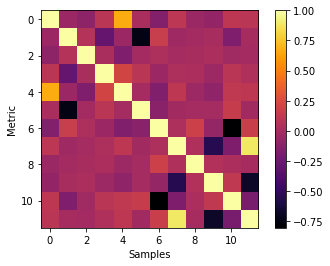

In [8]:
plt.imshow(my_rho,cmap='inferno')
plt.colorbar()
plt.ylabel('Metric')
plt.xlabel('Samples')
plt.show()

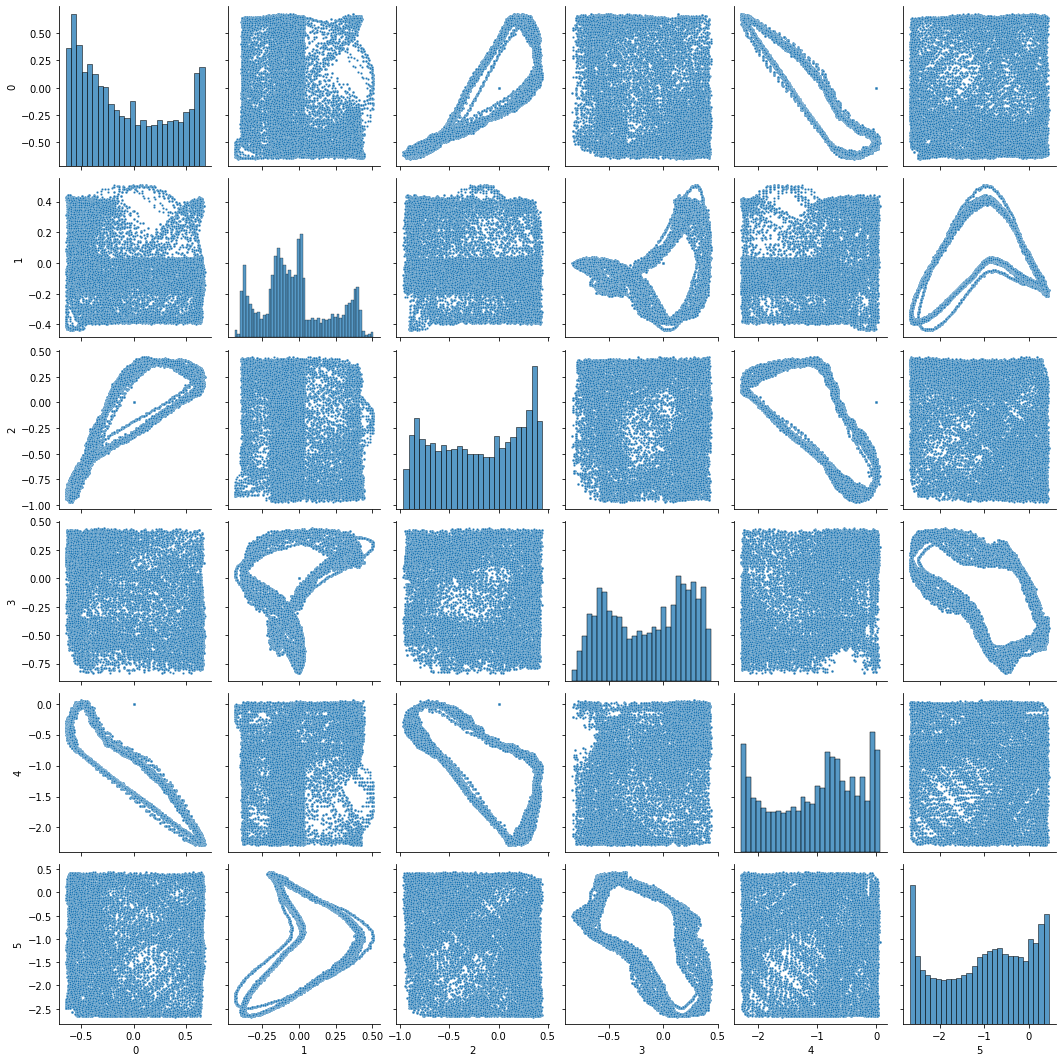

In [ ]:
import seaborn as sns
sns.pairplot(X0[1],plot_kws={"s": 5})

Text(0, 0.5, 'N muestras')

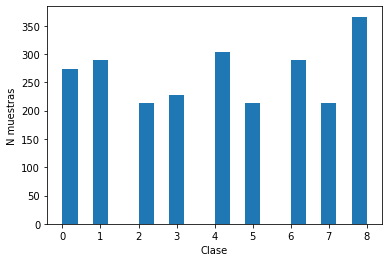

In [ ]:
plt.hist(Y2,bins=20)
plt.xlabel("Clase")
plt.ylabel("N muestras")

**Análisis de datos**
----

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

XX = X2.reshape(len(X2),-1)
pca = PCA(n_components=100, random_state=28)
pca.fit(XX)
xx = pca.transform(XX)

pca_graph = PCA(n_components=2, random_state=20)
pca_graph.fit(XX)
xx_graph = pca_graph.transform(XX)

kmeans = KMeans(n_clusters=9, random_state=22)
kmeans.fit(xx)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=9, random_state=22)

In [10]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=4, algorithm='ball_tree')
knn.fit(xx)

NearestNeighbors(algorithm='ball_tree', n_neighbors=4)

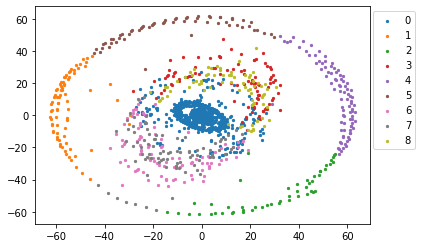

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
for lbl in np.unique(kmeans.labels_):
    indices = np.where(kmeans.labels_ == lbl)
    xx1 = xx[:,0][indices]
    xx2 = xx[:,1][indices]
    sc = ax.scatter(xx1, xx2, s=5, alpha=1, label=str(lbl))

ax.legend(bbox_to_anchor=(1.15,1))

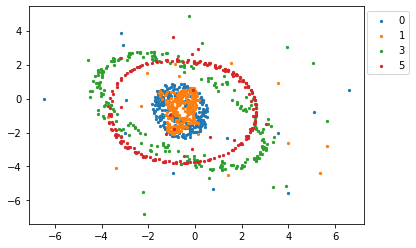

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
#np.unique(Y2)
for lbl in np.unique(Y2)[[0,1,3,5]]:
    indices = np.where(Y2 == lbl)
    xx1 = xx[:,0][indices]
    xx2 = xx[:,1][indices]
    sc = ax.scatter(xx1, xx2, s=5, alpha=1, label=str(lbl))

ax.legend(bbox_to_anchor=(1.15,1))

In [ ]:
dix

{'10hz': 4,
 '10hz_de': 1,
 '15hz': 5,
 '15hz_de': 6,
 '20hz': 3,
 '20hz_50': 2,
 '20hz_de': 0,
 '5hz': 7,
 '7hz': 8}

(-75.0, 75.0)

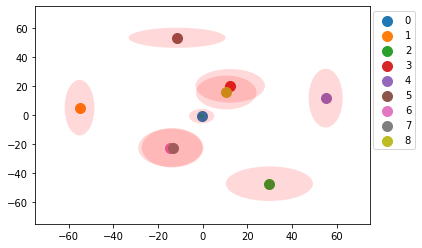

In [ ]:
from matplotlib.patches import Ellipse

fig = plt.figure()
ax = fig.add_subplot(111)
for lbl in np.unique(kmeans.labels_):
    indices = np.where(kmeans.labels_ == lbl)
    xx1 = np.mean(xx[:,0][indices])
    xx2 = np.mean(xx[:,1][indices])
    x_var1 = np.std(xx[:,0][indices])
    x_var2 = np.std(xx[:,1][indices])
    sc = ax.scatter(xx1, xx2, s=100, alpha=1, label=str(lbl))
    e = Ellipse(xy=(xx1,xx2),width=2*x_var1,height=2*x_var2)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.15)
    e.set_facecolor('r')

indices = np.where(np.array(Y2)==3)
xx1 = np.mean(xx[:,0][indices])
xx2 = np.mean(xx[:,1][indices])
x_var1 = np.std(xx[:,0][indices])
x_var2 = np.std(xx[:,1][indices])
e = Ellipse(xy=(xx1,xx2),width=2*x_var1,height=2*x_var2)
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_alpha(0.3)
e.set_facecolor('g')

ax.legend(bbox_to_anchor=(1.15,1))

ax.set_xlim(-75,75)
ax.set_ylim(-75,75)

In [ ]:
#distances, indices = knn.kneighbors(xx)

Z = knn.predict(xx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, Z, cmap=cmap_light)
# Plot also the training points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y],
                palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

plt.show()

AttributeError: ignored

(-50.0, 50.0)

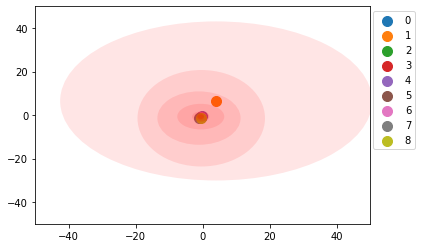

In [ ]:
#Clases reales
fig = plt.figure()
ax = fig.add_subplot(111)
for lbl in np.unique(Y2):
    indices = np.where(Y2 == lbl)
    xx1 = np.mean(xx[:,0][indices])
    xx2 = np.mean(xx[:,1][indices])
    x_var1 = np.std(xx[:,0][indices])
    x_var2 = np.std(xx[:,1][indices])
    sc = ax.scatter(xx1, xx2, s=100, alpha=1, label=str(lbl))
    e = Ellipse(xy=(xx1,xx2),width=2*x_var1,height=2*x_var2)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor('r')

ax.legend(bbox_to_anchor=(1.15,1))
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)

**Preprocesamiento**
----

In [ ]:
from sklearn.model_selection import train_test_split

def one_hot_encode(y, nclasses):
  y_one_hot = []
  for j in range(len(y)):
    a = np.zeros(nclasses)
    a[y[j]] = 1.
    y_one_hot.append(a)
  return np.array(y_one_hot)

Y2 = one_hot_encode(Y2,nclasses)

X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("train size: ", len(X_train))
print("validate size: ", len(X_test))
print("test_ size: ", len(X_val))

train size:  1433
validate size:  478
test_ size:  478


In [ ]:
# transforma los input en signal images
train_X = signal_images(X_train)
validate_X = signal_images(X_val)
test_X = signal_images(X_test)

# Agrega ruido a la entrada
train_noise = tf.random.normal(shape = tf.shape(train_X), mean = 0.0, stddev = 1.0, dtype = tf.float32)
validate_noise = tf.random.normal(shape = tf.shape(validate_X), mean = 0.0, stddev = 1.0, dtype = tf.float32)
test_noise = tf.random.normal(shape = tf.shape(test_X), mean = 0.0, stddev = 1.0, dtype = tf.float32)

# FFT y escalado
#train_X = transform_scale(train_X,train_noise)
#validate_X = transform_scale(validate_X,validate_noise)
#test_X = transform_scale(test_X,test_noise)
train_X = transform_scale(train_X)
validate_X = transform_scale(validate_X)
test_X = transform_scale(test_X)

chanDim = -1
train_X = tf.reshape(train_X, shape = [-1, train_X.shape[1], train_X.shape[2], 1])
test_X = tf.reshape(test_X, shape = [-1, test_X.shape[1], test_X.shape[2], 1])

train_X.shape

TensorShape([1433, 13, 53, 1])

In [ ]:
XX = tf.reshape(train_X,shape=[len(train_X),-1]).numpy()
pca = PCA(n_components=50, random_state=22)
pca.fit(XX)
xx = pca.transform(XX)

pca_graph = PCA(n_components=2, random_state=22)
pca_graph.fit(XX)
xx_graph = pca.transform(XX)

kmeans = KMeans(n_clusters=9,n_jobs=-1, random_state=22)
kmeans.fit(xx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

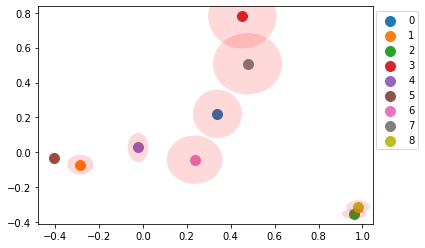

In [ ]:
#Post procesamiento
fig = plt.figure()
ax = fig.add_subplot(111)
for lbl in np.unique(kmeans.labels_):
    indices = np.where(kmeans.labels_ == lbl)
    xx1 = np.mean(xx[:,0][indices])
    xx2 = np.mean(xx[:,1][indices])
    x_var1 = np.std(xx[:,0][indices])
    x_var2 = np.std(xx[:,1][indices])
    sc = ax.scatter(xx1, xx2, s=100, alpha=1, label=str(lbl))
    e = Ellipse(xy=(xx1,xx2),width=2*x_var1,height=2*x_var2)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.15)
    e.set_facecolor('r')

indices = np.where(np.array(y_test.argmax(1))==3)
xx1 = xx[:,0][indices]
xx2 = xx[:,1][indices]
#ax.scatter(xx1, xx2,c='g', s=5, alpha=0.8, label="normalidad")

ax.legend(bbox_to_anchor=(1.15,1))

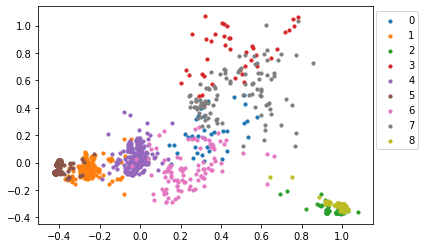

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for lbl in np.unique(kmeans.labels_):
    indices = np.where(kmeans.labels_ == lbl)
    xx1 = xx[:,0][indices]
    xx2 = xx[:,1][indices]
    sc = ax.scatter(xx1, xx2, s=10, alpha=1, label=str(lbl))

ax.legend(bbox_to_anchor=(1.15,1))

**Entrenamiento de modelos**
------

In [ ]:
from keras.layers import Input
from keras import layers, Model
# Red convolucional
filter_1 = 4
filter_2 = 2*filter_1
A1 = Input(shape=train_X.shape[1:],name='A1')
A2 = layers.Conv2D(filter_1, (5, 5), padding="same",activation='relu', name='A2')(A1)
A3 = layers.BatchNormalization(axis=chanDim, name='A3')(A2)
A4 = layers.GlobalAveragePooling2D(name='A4')(A3)
A5 = layers.Dense(filter_1//16,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'A5')(A4)
A6 = layers.Dense(filter_1,activation='sigmoid',
                       kernel_initializer = tf.keras.initializers.GlorotNormal(), name= 'A6')(A5)
AA = layers.Dropout(0.2, name='AA')(A6)
A7 = tf.multiply(A3, tf.reshape(AA, shape = [-1, 1, 1, filter_1]))

B1 = layers.Conv2D(filter_2, (3, 3), padding="same",activation='relu', name='B1')(A7)
B2 = layers.BatchNormalization(axis=chanDim, name='B2')(B1)
B3 = layers.GlobalAveragePooling2D(name='B3')(B2)
B4 = layers.Dense(filter_2//16,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'B4')(B3)
B5 = layers.Dense(filter_2,activation='sigmoid',
                       kernel_initializer = tf.keras.initializers.GlorotNormal(), name= 'B5')(B4)

B6 = tf.multiply(B2,tf.reshape(B5, shape = [-1, 1, 1, filter_2]))

C1 = layers.Flatten(name = 'C1')(B6)
C2 = layers.Dense(9,activation='softmax',name='C2')(C1)

merged1 = Model(inputs=[A1],outputs=[C2])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-4)
merged1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_s = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", min_delta = 0.0005, patience = 8, restore_best_weights = True)

history1 = merged1.fit(train_X,y_train, epochs=50, validation_data=(validate_X, y_val),batch_size = 16, callbacks=[early_s])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
90/90 [==============================] - 3s 25ms/step - loss: 0.6626 - accuracy: 0.8144 - val_loss: 2.1241 - val_accuracy: 0.1987
Epoch 2/50
90/90 [==============================] - 2s 23ms/step - loss: 0.1359 - accuracy: 0.9805 - val_loss: 1.9928 - val_accuracy: 0.4665
Epoch 3/50
90/90 [==============================] - 2s 24ms/step - loss: 0.0721 - accuracy: 0.9923 - val_loss: 1.7573 - val_accuracy: 0.5377
Epoch 4/50
90/90 [==============================] - 2s 23ms/step - loss: 0.0435 - accuracy: 0.9923 - val_loss: 1.1902 - val_accuracy: 0.9623
Epoch 5/50
90/90 [==============================] - 2s 23ms/step - loss: 0.0302 - accuracy: 0.9958 - val_loss: 0.7351 - val_accuracy: 0.8640
Epoch 6/50
90/90 [==============================] - 2s 23ms/step - loss: 0.0226 - accuracy: 0.9979 - val_loss: 0.4755 - val_accuracy: 0.9038
Epoch 7/50
90/90 [==============================] - 2s 23ms/step - loss: 0.0175 - accuracy: 0.9986 - val_loss: 0.0760 - val_accuracy: 0.9791
Epoch 8/50
90

Loss: 0.06243693828582764
Accuracy: 0.9832636117935181


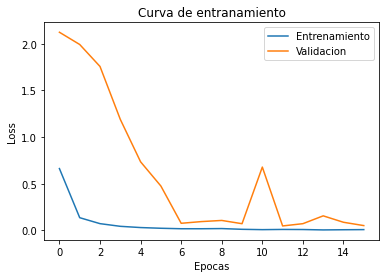

In [ ]:
loss, acc = merged1.evaluate(test_X, y_test, verbose = 0)
print("Loss:", loss)
print("Accuracy:", acc)

plt.title("Curva de entranamiento")
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.plot(history1.epoch, history1.history['loss'],
           label='Entrenamiento')
plt.plot(history1.epoch, history1.history['val_loss'],
           label = 'Validacion')
plt.legend()
plt.show()

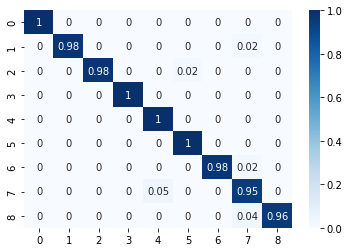

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = merged1.predict(test_X)

cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import recall_score, accuracy_score

print(recall_score(y_test.argmax(1), y_pred.argmax(1),average='macro'))
print(accuracy_score(y_test.argmax(1), y_pred.argmax(1)))

0.9839319343556632
0.9832635983263598


In [ ]:
merged1.save_weights("clasificador.h5")

In [ ]:
# Modelo mixto
dropout_rate = 0.3
filter_1 = 8
filter_2 = 2*filter_1
A1 = Input(shape=train_X.shape[1:],name='A1')
A2 = layers.Conv2D(filter_1, (5, 5), padding="same",activation='relu', name='A2')(A1)
A3 = layers.BatchNormalization(axis=chanDim, name='A3')(A2)
A4 = layers.GlobalAveragePooling2D(name='A4')(A3)
A5 = layers.Dense(filter_1//16,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'A5')(A4)
A6 = layers.Dense(filter_1,activation='sigmoid',
                       kernel_initializer = tf.keras.initializers.GlorotNormal(), name= 'A6')(A5)
AA = layers.Dropout(dropout_rate, name='AA')(A6)
A7 = tf.multiply(A3, tf.reshape(AA, shape = [-1, 1, 1, filter_1]))

B1 = layers.Conv2D(filter_2, (3, 3), padding="same",activation='relu', name='B1')(A7)
B2 = layers.BatchNormalization(axis=chanDim, name='B2')(B1)
B3 = layers.GlobalAveragePooling2D(name='B3')(B2)
B4 = layers.Dense(filter_2//16,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'B4')(B3)
B5 = layers.Dense(filter_2,activation='sigmoid',
                       kernel_initializer = tf.keras.initializers.GlorotNormal(), name= 'B5')(B4)
BB = layers.Dropout(dropout_rate, name='BB')(B5)
B6 = tf.multiply(B2,tf.reshape(BB, shape = [-1, 1, 1, filter_2]))
B7 = layers.Flatten(name = 'B7')(B6)
B8 = layers.Dense(256, activation='relu',name='B8')(B7)
B9 = layers.Dense(64, activation='relu',name='B9')(B8)

C1 = tf.reshape(A1, shape = [-1, train_X.shape[1], train_X.shape[2]])
C2 = layers.LSTM(128,activation='relu', return_sequences=True, name='C2')(C1)
C3 = layers.Dropout(0.2, name='C3')(C2)

D1 = layers.LSTM(256,activation='relu',return_sequences=True, name='D1')(C3)
D2 = layers.Dropout(dropout_rate, name='D2')(D1)

E1 = layers.LSTM(256,activation='relu', name='E1')(D2)
E2 = layers.Dropout(dropout_rate, name='E2')(E1)
E3 = layers.Dense(128,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'E3')(E2)
E4 = layers.Dense(64,activation='relu',name='E4')(E3)
E5 = layers.Dropout(dropout_rate)(E4)

F1 = layers.Concatenate(axis=1)([B9,E5])
F2 = layers.Dense(9,activation='softmax',name='F2')(F1)

merged = Model(inputs=[A1],outputs=[F2])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-4)
merged.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = merged.fit(train_X,y_train, epochs=50, validation_data=(validate_X, y_val),batch_size = 16, callbacks=[early_s])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
90/90 [==============================] - 19s 165ms/step - loss: 0.6310 - accuracy: 0.7830 - val_loss: 2.1866 - val_accuracy: 0.1444
Epoch 2/50
90/90 [==============================] - 13s 150ms/step - loss: 0.1245 - accuracy: 0.9567 - val_loss: 2.1402 - val_accuracy: 0.2741
Epoch 3/50
90/90 [==============================] - 14s 152ms/step - loss: 0.0704 - accuracy: 0.9833 - val_loss: 1.8873 - val_accuracy: 0.6967
Epoch 4/50
90/90 [==============================] - 15s 163ms/step - loss: 0.0306 - accuracy: 0.9909 - val_loss: 1.3982 - val_accuracy: 0.8075
Epoch 5/50
90/90 [==============================] - 14s 154ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 1.3199 - val_accuracy: 0.5649
Epoch 6/50
90/90 [==============================] - 14s 154ms/step - loss: 0.0271 - accuracy: 0.9902 - val_loss: 0.1314 - val_accuracy: 0.9833
Epoch 7/50
90/90 [==============================] - 15s 167ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.8785 - val_accuracy: 0.7238

Loss: 0.03582385554909706
Accuracy: 0.9853556752204895


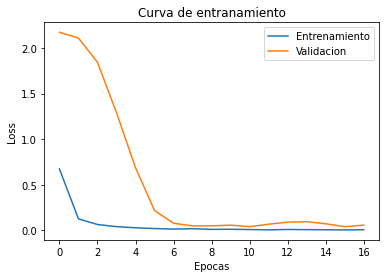

In [ ]:
loss, acc = merged.evaluate(test_X, y_test, verbose = 0)
print("Loss:", loss)
print("Accuracy:", acc)

plt.title("Curva de entranamiento")
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.plot(history1.epoch, history1.history['loss'],
           label='Entrenamiento')
plt.plot(history1.epoch, history1.history['val_loss'],
           label = 'Validacion')
plt.legend()
plt.show()

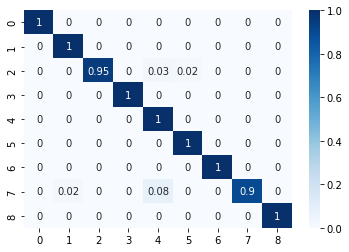

In [ ]:
y_pred = merged.predict(test_X)

cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
print(recall_score(y_test.argmax(1), y_pred.argmax(1),average='macro'))
print(accuracy_score(y_test.argmax(1), y_pred.argmax(1)))

0.9832391713747646
0.9853556485355649


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test.argmax(1), y_pred.argmax(1),average='macro')

0.9840094159600778

**Predictor**
_____

In [ ]:
gap = 150

x_norm = []
y_norm = []
for i in range(len(Y)-gap):
  clase = dix[Y[i]]
  if clase == 2:
    x_norm.append(X[i])
    y_norm.append(X[i+gap])

x_norm = np.asarray(x_norm).astype('float32')
y_norm = np.asarray(y_norm).astype('float32')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

train_X = X_train.reshape([-1, X_train.shape[1], 1])
test_X = X_test.reshape([-1, X_train.shape[1], 1])

In [ ]:
X_train.shape[1:]

(6,)

In [ ]:
from tensorflow.keras import datasets, layers, Model, Input
# Red LSTM

A1 = Input(shape=train_X.shape[1:], name='A1')
A2 = layers.LSTM(128,activation='relu', return_sequences=True, name='A2')(A1)
A3 = layers.Dropout(0.2, name='A3')(A2)

B1 = layers.LSTM(256,activation='relu',return_sequences=True, name='B1')(A3)
B2 = layers.Dropout(0.2, name='B2')(B1)
#B3 = layers.Dense(32,activation='relu', kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'B3')(B2)

C1 = layers.LSTM(512,activation='relu', name='C1')(B2)
C2 = layers.Dropout(0.2, name='C2')(C1)
C3 = layers.Dense(64,activation='relu',
                       kernel_initializer = tf.keras.initializers.VarianceScaling(), name= 'C3')(C2)
C4 = layers.Dense(256,activation='relu')(C3)
C5 = layers.Dense(64,activation='relu')(C4)

D1 = layers.Dense(train_X.shape[1],name='D1',activation='linear')(C4)

predictor = Model(inputs=[A1],outputs=[D1])
#plot_model(merged,to_file='demo.png',show_shapes=True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)
predictor.compile(loss=tf.keras.losses.Huber(delta=1.0, reduction="auto"), optimizer=opt, metrics=['mse'])

early_s = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.001, patience = 10, restore_best_weights = True)
history = predictor.fit(train_X,y_train, epochs=35, validation_data=(test_X, y_test), callbacks=[early_s])

Epoch 1/35
570/570 [==============================] - 146s 251ms/step - loss: 21.7279 - mse: 3254.5735 - val_loss: 17.9715 - val_mse: 2550.2048
Epoch 2/35
570/570 [==============================] - 145s 255ms/step - loss: 14.6429 - mse: 1816.6401 - val_loss: 13.0440 - val_mse: 1632.0717
Epoch 3/35
570/570 [==============================] - 146s 256ms/step - loss: 12.4866 - mse: 1447.7517 - val_loss: 11.3817 - val_mse: 1207.2776
Epoch 4/35
570/570 [==============================] - 148s 260ms/step - loss: 11.7099 - mse: 1334.3611 - val_loss: 10.7579 - val_mse: 1213.7203
Epoch 5/35
570/570 [==============================] - 149s 261ms/step - loss: 11.1048 - mse: 1256.6481 - val_loss: 10.1603 - val_mse: 1077.3884
Epoch 6/35
570/570 [==============================] - 151s 264ms/step - loss: 10.7696 - mse: 1216.2990 - val_loss: 9.7884 - val_mse: 1028.5646
Epoch 7/35
570/570 [==============================] - 145s 255ms/step - loss: 10.4109 - mse: 1173.3591 - val_loss: 9.6860 - val_mse: 997.

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

y_pred_norm = predictor.predict(test_X)

MSE(y_pred_norm,y_test)

256.60754

In [ ]:
y_pp = tf.reshape(y_pred_norm,shape=[len(y_pred_norm),-1]).numpy()
pca = PCA(n_components=1, random_state=22)
pca.fit(y_pp)
y_pp = pca.transform(y_pp)

y_tt = tf.reshape(y_test,shape=[len(y_test),-1]).numpy()
pca = PCA(n_components=1, random_state=22)
pca.fit(y_tt)
y_tt = pca.transform(y_tt)

plt.plot(y_pp,linewidth=0.2)
plt.plot(y_tt,linewidth=0.12)
plt.xlabel("Tiempo")
plt.ylabel("Proyección variables")
leg = plt.legend(["Predicción","Real"],bbox_to_anchor=(1,1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)